# Importando Librerias

In [51]:
import pandas as pd 
import numpy as np 
import sys
import os
import warnings
import itertools
warnings.filterwarnings("ignore")
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot as plt
from pandas.plotting import lag_plot
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import calendar
import seaborn as sns
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns

Importando Dataset

In [2]:
#Haciendo conexion
def conexion():
    mainpath = "/Users/estilos/Documents/Developer/Anaconda_Proyects/Python/Datasets/BD"
    filename = "champagne/champagne.csv"
    fullpath = os.path.join(mainpath, filename)
    return fullpath

In [3]:
data = pd.read_csv(conexion(), delimiter = ',')
data.tail()

,Fecha,Sales
100,1972-05,4618
101,1972-06,5312
102,1972-07,4298
103,1972-08,1413
104,1972-09,5877


Creando rango de datos

In [4]:
dates = pd.date_range(start='1964-01-01', freq='MS', periods=len(data))
dates[0:5]

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01'],
              dtype='datetime64[ns]', freq='MS')

In [5]:
data.set_index(dates,inplace=True)
data.drop('Fecha',axis=1,inplace=True)

In [6]:
data.head()

,Sales
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


Partiendo los datos para predecir y testear

In [7]:
p80 = round(len(data)*.8)
data[:p80].tail(),data[p80:].head()

(            Sales
 1970-08-01   1738
 1970-09-01   5221
 1970-10-01   6424
 1970-11-01   9842
 1970-12-01  13076,
             Sales
 1971-01-01   3934
 1971-02-01   3162
 1971-03-01   4286
 1971-04-01   4676
 1971-05-01   5010)

# Modelando

In [8]:
train = data[:p80]
test = data[p80:]

Función para calcular error de pronóstico

In [9]:
#Recibe de parametros, los valores para hacer la prueba, y a la predicción
def Error_pro(testx, predex):
    # Error cuadratico medio (RMSE)
    rmse = np.sqrt(mean_squared_error(testx, predex))
    rmse = round(rmse, 3)
    # Error porcentual absoluto medio (MAPE)
    abs_error = np.abs(testx- predex)
    actual = testx
    mape = np.round(np.mean(abs_error/actual),3)
    return mape, rmse

Función para graficar

In [10]:
def Graph(data, predictions):
    ax = data.plot(label = 'Data', alpha = .7, linewidth=2.0, marker = 'o')
    predictions.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7), 
                     color = 'purple', linewidth=2.0, marker = 'o')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Sales')
    ax.set_title('Ventas de champagne')
    plt.legend()
    plt.show()

### Modelo 1: Autorregresivo (AR)

In [24]:
def Model_AR(train, test, data):
    model = AR(train)
    model_fit = model.fit()
    
    #Prediciendo
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    
    #Graficando
    Graph(data, predictions)
    
    #Calculando error de pronostico
    mape, rmse = Error_pro(test['Sales'], predictions)
    
    print('Metodo',': ','AR', ', MAPE: ',mape, ', RMSE ',rmse)

### Modelo 2: Media móvil autorregresivo(ARMA)

In [25]:
def Model_ARMA(train, test, data):
    #El modelo implica especificar el orden para el modelo AR (p) y MA (q)
    #Defina los parámetros "p" y "q"
    p = range(0,7)
    q = range(0,1)
    
    #Genera todas las combinaciones de p, q
    pq = list(itertools.product(p,q))

    # Buscar el mejor parámetro p y q
    best_aic = np.inf
    best_pq = None
    temp_model = None
    for x in pq: 
        temp_model = ARMA(train,order = x)
        results = temp_model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pq = x
            
    #usando el mejor parámetro en el modelo ( "best_pq")
    model = ARMA(train,order= best_pq)
    model_fit = model.fit()
    
    #Prediciendo
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
    
    #Graficando
    Graph(data, predictions)
    
    #Calculando error de pronostico
    mape, rmse = Error_pro(test['Sales'], predictions)
    print('Metodo',': ','ARMA', ', MAPE: ',mape, ', RMSE ',rmse)
    

### Modelo 3: Media móvil integrada autorregresiva (ARIMA)

In [26]:
def Model_ARIMA(train, test, data):
    #definimos los parametros "p", "d" y "q"
    p = range(0, 8)
    d = range(0, 2)
    q = range(0, 1)
    
    #Generamos todas las combinaciones p, d y q
    pdq = list(itertools.product(p, d, q))
    
    #Buscar el mejor parámetro p,d,q
    best_aic = np.inf
    best_pdq = None
    temp_model = None
    for x in pdq:   
        temp_model = ARIMA(train,order=x)
        results = temp_model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = x
            
    #Usando el mejor parámetro en el modelo ("best_pdq")
    model = ARIMA(train,order= best_pdq)
    model_fit = model.fit()
    
    #prediciendo
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    
    #Graficando
    Graph(data, predictions)
    
    #Calculando error de pronóstico
    mape, rmse = Error_pro(test['Sales'], predictions)
    print('Metodo',': ','ARIMA', ', MAPE: ',mape, ', RMSE ',rmse)

### Media móvil integrada autorregresiva estacional (SARIMA)

In [49]:
def Model_SARIMA(train, test, data):
    
    #Definimos los parametros p, d, q con valores entre 0 y 2
    p = d = q = range(0, 2)
    
    #Generamos todas las combinaciones p, d, q
    pdq = list(itertools.product(p, d, q))
    
    #Generamos todas las combinaciones estacionales p, d, q
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    #Buscar el mejor parámetro p, d, q
    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    temp_model = None
    for x in pdq:   
        for x_seasonal in seasonal_pdq: 
            temp_model = SARIMAX(train,order=x,seasonal_order = x_seasonal,enforce_invertibility=False,
                                 enforce_stationarity=False)
            results = temp_model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = x
                best_seasonal_pdq = x_seasonal
    
    #Usando el mejor parámetro en el modelo
    model = SARIMAX(train,order=best_pdq,seasonal_order=best_seasonal_pdq,enforce_invertibility=False,
                                 enforce_stationarity=False)
    model_fit = model.fit()
    
    #Prediciendo
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    
    #Graficando
    Graph(data, predictions)
    
    #Calculando error de pronóstico
    mape, rmse = Error_pro(test['Sales'], predictions)
    print('Metodo',': ','SARIMA', ', MAPE: ',mape, ', RMSE ',rmse)

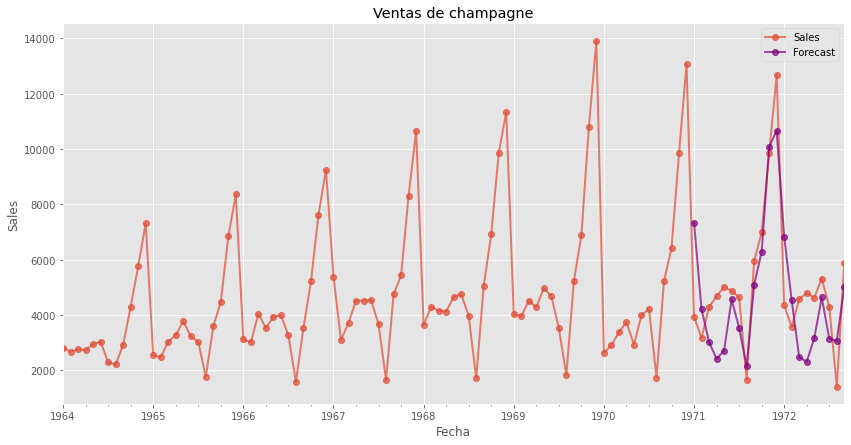

Metodo :  AR , MAPE:  0.347 , RMSE  1641.779


In [27]:
Model_AR(train, test, data)

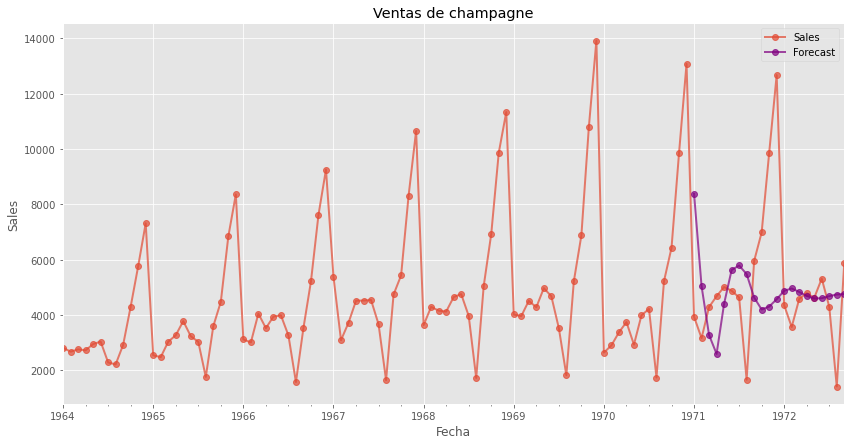

Metodo :  ARMA , MAPE:  0.496 , RMSE  2817.34


In [28]:
Model_ARMA(train, test, data)

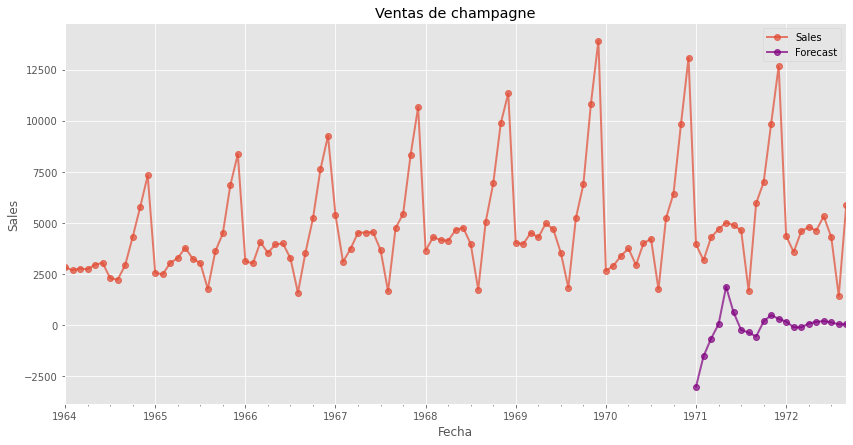

Metodo :  ARIMA , MAPE:  1.052 , RMSE  5683.047


In [29]:
Model_ARIMA(train, test, data)

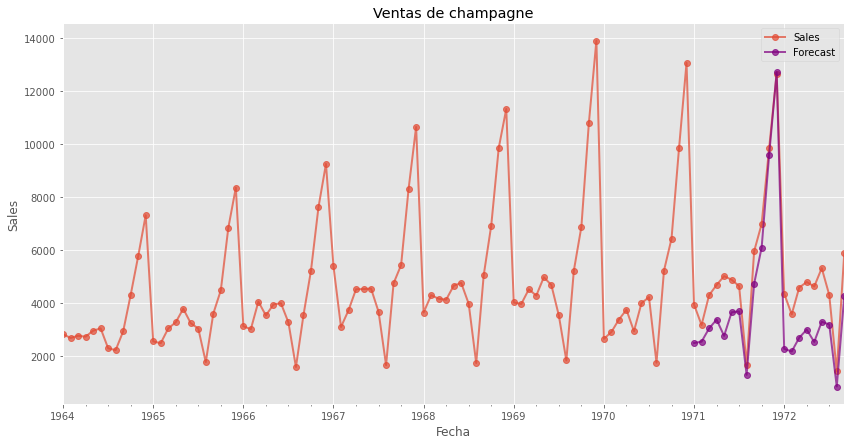

Metodo :  SARIMA , MAPE:  0.29 , RMSE  1409.015


In [52]:
Model_SARIMA(train, test, data)